# Warwick SEIRD Model Optimisation

In this notebook we present how to use the `epimodels` module to perform parameter optimisation for the parameters specified by the Warwick Household model, using time-dependent region-specific contact matrices.

The analysis is run for:
 - Dates: **15 Feb 2020** - **25 June 2020**;
 - PHE regions of interest: **London**.

We use realistic serology and mortality data extracted from the REACT survey and GOV.UK data.

*The Warwick model is built by University of Warwick.*

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
import scipy
from scipy.stats import gamma, nbinom, norm
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(28)

## Model Setup
### Define setup matrices for the Roche Model

In [2]:
# Populate the model
total_days =  132
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
house_matrices_region = []
school_matrices_region = []
work_matrices_region = []
other_matrices_region = []

### Fixed
# Initial state of the system
house_weeks_matrices_region = []
school_weeks_matrices_region = []
work_weeks_matrices_region = []
other_weeks_matrices_region = []

for r in regions:
    path = os.path.join('../../data/final_contact_matrices/house_BASE.csv')
    house_region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
    house_regional = em.RegionMatrix(r, age_groups, house_region_data_matrix)
    house_weeks_matrices_region.append(house_regional)

    path2 = os.path.join('../../data/final_contact_matrices/school_BASE.csv')
    school_region_data_matrix = pd.read_csv(path2, header=None, dtype=np.float64)
    school_regional = em.RegionMatrix(r, age_groups, school_region_data_matrix)
    school_weeks_matrices_region.append(school_regional)

    path3 = os.path.join('../../data/final_contact_matrices/work_BASE.csv')
    work_region_data_matrix = pd.read_csv(path3, header=None, dtype=np.float64)
    work_regional = em.RegionMatrix(r, age_groups, work_region_data_matrix)
    work_weeks_matrices_region.append(work_regional)

    path4 = os.path.join('../../data/final_contact_matrices/other_BASE.csv')
    other_region_data_matrix = pd.read_csv(path4, header=None, dtype=np.float64)
    other_regional = em.RegionMatrix(r, age_groups, other_region_data_matrix)
    other_weeks_matrices_region.append(other_regional)

house_matrices_region.append(house_weeks_matrices_region)
school_matrices_region.append(school_weeks_matrices_region)
work_matrices_region.append(work_weeks_matrices_region)
other_matrices_region.append(other_weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
house_matrices_contact = [contacts]
school_matrices_contact = [contacts]
work_matrices_contact = [contacts]
other_matrices_contact = [contacts]


# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]

### Set the parameters and initial conditions of the model and bundle everything together

In [3]:
# Instantiate model
model = em.WarwickSEIRModel()

# Set the region names, contact and regional data of the model
model.set_regions(regions)
model.set_age_groups(age_groups)
model.read_contact_data(house_matrices_contact, school_matrices_contact, work_matrices_contact, other_matrices_contact, time_changes_contact)
model.read_regional_data(house_matrices_region, school_matrices_region, work_matrices_region, other_matrices_region, time_changes_region)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[1]

# Initial number of infectives
ICs_multiplier = 40
infectives = (ICs_multiplier * np.ones((len(regions), len(age_groups)))).tolist()

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

In [4]:
# Set regional and time dependent parameters
regional_parameters = em.WarwickRegParameters(
    model=model,
    region_index=1,
    H=0.8 * np.ones(len(regions))
)

# Set ICs parameters
ICs = em.WarwickICs(
    model=model,
    susceptibles_IC=[susceptibles],
    exposed_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_f_IC=infectives,
    detected_qf_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_sd_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_su_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    detected_qs_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_f_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_s_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    undetected_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
disease_parameters = em.WarwickDiseaseParameters(
    model=model,
    tau=0.4,
    d=0.4 * np.ones(len(age_groups))
)

# Set transmission parameters
transmission_parameters = em.WarwickTransmission(
    model=model,
    epsilon=0.5,
    gamma=1,
    sigma=0.5 * np.ones(len(age_groups))
)

# Set other simulation parameters
simulation_parameters = em.WarwickSimParameters(
    model=model,
    method='RK45',
    times=times
)

# Set all parameters in the controller
parameters = em.WarwickParametersController(
    model=model,
    regional_parameters=regional_parameters,
    ICs=ICs,
    disease_parameters=disease_parameters,
    transmission_parameters=transmission_parameters,
    simulation_parameters=simulation_parameters
)

In [5]:
def update_age_groups(population, parameter_vector):
    """
    """
    new_vector = np.empty(8)

    ind_old = [
        np.array([0]),
        np.array([0]),
        np.array(range(1, 3)),
        np.array(range(3, 5)),
        np.array(range(5, 9)),
        np.array(range(9, 13)),
        np.array(range(13, 15)),
        np.array(range(15, 21))]

    for _ in range(8):
        new_vector[_] = np.average(
            np.array(parameter_vector)[ind_old[_][:, None]],
            weights=population[ind_old[_][:, None]])

    return new_vector

In [6]:
# Read extended age-group data for optimisation
extended_susceptibles = np.loadtxt('../../data/england_population/UK_PP.csv', delimiter=',').astype(int)
extended_infectives = np.multiply(
    np.loadtxt('../../data/england_population/UK_Ages.csv', delimiter=','), extended_susceptibles).astype(int)

extended_house_cont_mat = np.loadtxt('../../data/england_population/UK_from_toH.csv', delimiter=',')
extended_school_cont_mat = np.loadtxt('../../data/england_population/UK_from_toS.csv', delimiter=',')
extended_work_cont_mat = np.loadtxt('../../data/england_population/UK_from_toW.csv', delimiter=',')
extended_other_cont_mat = np.loadtxt('../../data/england_population/UK_from_toO.csv', delimiter=',')

In [7]:
# Add folder path to data file
path = os.path.join('../../data/')

RF_df = pd.read_csv(
    os.path.join(path, 'risks_death/Risks_United Kingdom.csv'),
    dtype=np.float64)

param_df = pd.read_csv(
        os.path.join(path, 'global_parameters/parameters.csv'),
        dtype=np.float64)

pDtoH = update_age_groups(extended_susceptibles, RF_df['hospitalisation_risk'].tolist())
pHtoDeath = update_age_groups(extended_susceptibles, RF_df['death_risk'].tolist())

th_mean = param_df['hosp_lag'].tolist()[0]+0.00001
th_var = 12.1**2
theta = th_var / th_mean
k = th_mean / theta
dDtoH = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

td_mean = param_df['death_lag'].tolist()[0]
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
dHtoDeath = scipy.stats.gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()


### Simulate for one of the regions: **London**

In [8]:
# Simulate for all regions
output = []
new_infec = []
new_hosp = []
new_deaths = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output.append(model.simulate(parameters))
    new_infec.append(model.new_infections(output[-1]))
    new_hosp.append(model.new_hospitalisations(new_infec[-1], pDtoH, dDtoH))
    new_deaths.append(model.new_deaths(new_hosp[-1], pHtoDeath, dHtoDeath))

## Death and Serology data
### Read Tests data

In [10]:
# # Read in tests data from external files for realistic counts of tests
# tests = []

# for region in regions:
#     daily_tests = np.ones((len(times), len(age_groups)), dtype=int)
#     weekly_tests = np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=',')
#     for _, day in enumerate(np.arange(0, len(times), 7)):
#         daily_tests[day:(day+7), :]=weekly_tests[_, :] / 7
#     tests.append(daily_tests)

## Read Death and Serology data

In [11]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

In [12]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [13]:
# Set information
niu = 10**(-5) # float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

### Sample Death and Serology data

In [14]:
# # Sample death and positive test results data for all regions
# deaths_data = []
# positives_data = []

# for r, reg in enumerate(regions):
#     reg_deaths_data = np.empty((len(times), len(age_groups)))
#     reg_positives_data = np.empty(((len(times), len(age_groups))))
#     for t, _ in enumerate(times):
#         # Sample the number of deaths and positive test results in a given region on a given day
#         reg_deaths_data[t, :] = model.samples_deaths(new_deaths[r], niu, t)
#         reg_positives_data[t, :] = model.samples_positive_tests(output[r], tests[r][t, :], sens, spec, t)
#     deaths_data.append(np.asarray(reg_deaths_data, dtype=int))
#     positives_data.append(np.asarray(reg_positives_data, dtype=int))

### Export Death and Serology data

In [15]:
# # Export synthetic death and positive test results data for all regions to external files to save computation time
# path_ = 'inference_data/'

# for r, region in enumerate(regions):
#     path = os.path.join(path_, '{}_Syn_Deaths.csv'.format(region))
#     path1 = os.path.join(path_, '{}_Syn_Positives.csv'.format(region))

#     np.savetxt(path, deaths_data[r], fmt="%d", delimiter=',')
#     np.savetxt(path1, positives_data[r], fmt="%d",  delimiter=',')

### Read Death and Serology data

In [16]:
# # Read in synthetic death and positive data from external files
# deaths_data = []
# positives_data = []

# for region in regions:
#     deaths_data.append(np.loadtxt('inference_data/{}_Syn_Deaths.csv'.format(region), dtype=int, delimiter=','))
#     positives_data.append(np.loadtxt('inference_data/{}_Syn_Positives.csv'.format(region), dtype=int, delimiter=','))

In [17]:
# # Select the time points for which the death and serology data is known
# deaths_times = np.arange(1, total_days+1, 1).tolist()
# serology_times = np.arange(1, total_days+1, 1).tolist()

## Optimisation Procedure

In [18]:
# Initialise optimisation for the model
warwick_optimisation = em.inference.WarwickSEIRInfer(model)

# Add model, death, tests and NPIs data to the inference structure
warwick_optimisation.read_model_data(susceptibles, infectives)
warwick_optimisation.read_extended_population_structure(extended_susceptibles, extended_infectives)
warwick_optimisation.read_extended_contact_matrices(
    extended_house_cont_mat, extended_school_cont_mat,
    extended_work_cont_mat, extended_other_cont_mat)
warwick_optimisation.read_deaths_data(deaths_data, deaths_times)
warwick_optimisation.read_delay_data(pDtoH, dDtoH, pHtoDeath, dHtoDeath)
warwick_optimisation.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run optimisation structure
found, log_post_value = warwick_optimisation.optimisation_problem_setup(times, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Current   Time m:s
0     7     -71262.6  -71262.6    0:00.4
1     14    -69524.53 -69524.53   0:00.6
2     21    -69524.53 -71383.82   0:00.8
3     28    -69524.53 -70481.24   0:01.2
20    147   -63325.44 -63690.39   0:10.3
40    287   -53648.48 -54621.44   0:27.8
60    427   -45562.2  -45562.2    0:55.8
80    567   -41828.01 -41828.01   1:40.2
100   707   -41722.75 -41757.21   2:23.7
120   847   -41697.57 -41697.74   3:04.7
140   987   -41695.63 -41696.37   3:50.4
160   1127  -41695.51 -41695.51   4:37.2
180   1267  -41694.15 -41694.24   5:23.8
200   1407  -41694.14 -41694.16   6:13.7
220   1547  -41694.06 -41694.06   7:02.0
240   1687  -41694.05 -41694.05   7:52.8
260   1827  -41694.05 -41694.05   8:40.2
269   1883  -41694.05 -41694.05   9:02.2
Halting: No significant change for 100 iterations.
[0.21929906 0.29923321 9.99999952] -41694.

### Run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

In [20]:
n_parameters = model.n_parameters()

predicted_new_infec = []
predicted_deaths = []
#predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(model.regions):
    parameters.simulation_parameters.region_index = r + 1

    d, sigma, gamma = warwick_optimisation.ll.compute_updated_param(found[0], found[1])

    parameters.disease_parameters.tau = found[1]
    parameters.disease_parameters.d = d

    parameters.transmission_parameters.epsilon = found[2]
    parameters.transmission_parameters.gamma = gamma
    parameters.transmission_parameters.sigma = sigma
    
    #r_fix = np.empty(len(times))
    model_reg_deaths_data = np.empty(len(times))

    #m_fix = em.MultiTimesInfectivity(
    #    matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region, parameters[0], dI, susceptibles)

    # Run model and number of new infections for all age groups
    model_output = model.simulate(parameters)

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    age_model_reg_new_hosp = model.new_hospitalisations(age_model_reg_new_infections, pDtoH, dDtoH)
    model_reg_new_hosp = age_model_reg_new_hosp.sum(axis=1)

    age_model_reg_new_deaths = model.new_deaths(age_model_reg_new_hosp, pHtoDeath, dHtoDeath)

    for t, time in enumerate(times):
    #    r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)], temp_variation=parameters[8][r][t])
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(t, age_model_reg_new_deaths))
    
    predicted_new_infec.append(np.array(model_reg_new_infections))
    predicted_deaths.append(model_reg_deaths_data)
    #predicted_reprod_num.append(r_fix)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
#predicted_reprod_num = np.array(predicted_reprod_num)

## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [21]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

### Select predicted quantities to plot

In [22]:
# Set up traces to plot
new_infec_pred = []
deaths_pred = []
#reprod_num_pred = []

for r, _ in enumerate(model.regions):
    # Compute the prediction 
    new_infec_pred.append(predicted_new_infec[r,:])
    deaths_pred.append(predicted_deaths[r,:])
    #reprod_num_pred.append(predicted_reprod_num[r,:])

### Plot observed versus predicted using model with optimised parameters

In [23]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    #fig.add_trace(
    #    go.Scatter(
    #        x=times,
    #        y=reprod_num_pred[r].tolist(),
    #        mode='lines',
    #        name=trace_name[r],
    #        showlegend=False,
    #        line_color=colours[r]
    #    ),
    #    row= 3,
    #    col= 1
    #)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-3-optimisation.pdf')
fig.show()

<ipython-input-23-e48c6bf424d7>:26: RuntimeWarning:

invalid value encountered in true_divide



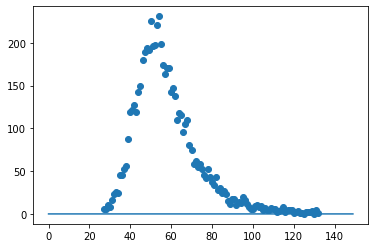

In [24]:
plt.plot(model.actual_deaths)
plt.scatter(deaths_times, np.sum(deaths_data[r], axis=1).tolist()[:len(deaths_times)])

In [25]:
p_after = parameters()

In [27]:
warwick_optimisation.ll(found)
p = warwick_optimisation.ll._parameters
p_found = list(deepflatten(p, ignore=str))

In [28]:
for p1, p2 in zip(p_after, p_found):
    print(p1, p2)

1 1
117840 117840
488164 488164
1140597 1140597
1033029 1033029
3050671 3050671
2050173 2050173
586472 586472
495043 495043
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
40.0 40.0
40.0 40.0
40.0 40.0
40.0 40.0
40.0 40.0
40.0 40.0
40.0 40.0
40.0 40.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.7084434476743761 0.7084434